In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from torch_snippets import *
from pathlib import Path
from imutils import paths
from tqdm.auto import tqdm
import re

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
ORI_IMAGE_SIZE = 1024
TG_IMAGE_SIZE = 224

In [14]:
image_paths = list(paths.list_images('train'))
progress_bar = tqdm(total=len(image_paths), desc='Resizing images')

for image_path in image_paths:
    image_path = Path(image_path)
    image = Image.open(image_path)
    resized_image = image.resize((TG_IMAGE_SIZE, TG_IMAGE_SIZE))
    output_path = Path('train') / image_path.name
    
    resized_image.save(output_path)
    progress_bar.update(1)

progress_bar.close()

Resizing images:   0%|          | 0/3422 [00:00<?, ?it/s]

In [4]:
df = pd.read_csv('train.csv')
train_idx, val_idx = train_test_split(df.image_id.unique(), train_size=0.7, random_state=23)
train_df, val_df = df[df['image_id'].isin(train_idx)], df[df['image_id'].isin(val_idx)]
label2target = {'background': 0, 'wheat-head': 1}
target2label = {value: key for key, value in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [128]:
class WheatDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        super().__init__()
        self.w, self.h = TG_IMAGE_SIZE, TG_IMAGE_SIZE
        self.img_dir = img_dir
        self.annotations = df.copy()
        self.transform = transform
        self.images = df.image_id.unique()

    def __len__(self):
        return len(self.images)
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    def __getitem__(self, index):
        image_path = os.path.join(self.img_dir, self.images[index] + '.jpg')
        image = Image.open(image_path).convert('RGB')
        data = self.annotations[self.annotations['image_id'] == self.images[index]]
        boxes = data.get('bbox').values.tolist()
        for i in range(len(boxes)):
            boxes[i] = eval(boxes[i])
        boxes = np.array(boxes)
        boxes[:, [0, 2]] = boxes[:, [0, 2]] / ORI_IMAGE_SIZE * TG_IMAGE_SIZE
        boxes[:, [1, 3]] = boxes[:, [1, 3]] / ORI_IMAGE_SIZE * TG_IMAGE_SIZE
        label = ['wheat-head'] * len(data)

        if self.transform:
            # augmentations = self.transform(image=image, bboxes=boxes)
            # image = augmentations['image']
            # boxes = augmentations['bboxes']
            image = self.transform(image)
        
        target = {}
        target['boxes'] = torch.tensor(boxes).float()
        target['labels'] = torch.tensor([label2target[i] for i in label]).long()

        return image, target

In [129]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize()
])

In [133]:
train_dataset = WheatDataset(train_df, 'train', train_transform)

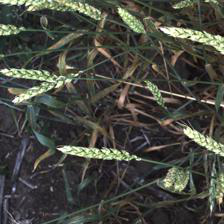

In [135]:
image, target = train_dataset[10]
image

In [136]:
target

{'boxes': tensor([[  0.0000,   0.0000,  47.6875,   6.3438],
         [139.1250,  78.0938,  31.0625,  31.2812],
         [ 10.2812,  71.0938,  71.7500,  35.8750],
         [ 44.1875,   0.0000,  66.7188,  22.0938],
         [  0.0000,  62.1250,  63.2188,  22.9688],
         [155.3125,  20.1250,  68.6875,  29.5312],
         [181.1250, 122.9375,  42.8750,  37.1875],
         [166.6875,   0.0000,  34.5625,  11.8125],
         [213.0625, 168.8750,  10.9375,  35.6562],
         [158.5938, 164.2812,  23.1875,  25.1562],
         [ 52.2812, 140.0000,  85.0938,  25.3750],
         [113.3125,   3.7188,  34.1250,  31.5000],
         [171.7188, 165.8125,  17.0625,  27.3438],
         [176.7500, 168.8750,  18.5938,  26.9062],
         [207.3750, 163.4062,  10.5000,  54.6875],
         [  0.0000,  21.6562,  30.4062,  17.9375],
         [ 26.4688,   0.0000,  52.0625,  15.3125],
         [ 51.1875,   0.0000,  56.2188,  24.2812]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1